### Train DAE

In [1]:
import math
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from diffusion.ddpm import Unet, GaussianDiffusion
from utils.dataset_h5 import H5ImagesDataset 

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_unet = Unet(
    dim=64,
    dim_mults=(1, 2, 4),
    flash_attn=False,
    channels=3, 
)

diffusion = GaussianDiffusion(
    base_unet,
    image_size=28,
    timesteps=1000,
    sampling_timesteps=250,
).to(device)


dae = Unet(
    dim=64,
    dim_mults=(1, 2, 4),
    flash_attn=False,
    channels=3,  
).to(device)

optimizer = torch.optim.Adam(dae.parameters(), lr=1e-4)

with torch.no_grad():
    alphas_cumprod = diffusion.alphas_cumprod.cpu() 
    target_var = 0.105
    t_dae = torch.argmin(torch.abs(1.0 - alphas_cumprod - target_var)).item()

t_dae = 200

print(f"Using t_dae = {t_dae}, 1 - alpha_bar_t ≈ {1 - alphas_cumprod[t_dae].item():.4f}")


data_dir = "./data"  
ds = H5ImagesDataset(data_dir) 
dl = DataLoader(ds, batch_size=128, shuffle=True, num_workers=0, pin_memory=False)

num_epochs = 501  

for epoch in range(num_epochs):
    dae.train()
    pbar = tqdm(dl, desc=f"Epoch {epoch+1}/{num_epochs}")

    for x0 in pbar:
        x0 = x0.to(device)  
        x0_norm = x0 * 2.0 - 1.0
        b = x0.shape[0]
        t = torch.full((b,), t_dae, device=device, dtype=torch.long)

        with torch.no_grad():
            x_t = diffusion.q_sample(x_start=x0_norm, t=t)

        pred_x0 = dae(x_t, t)
        loss = F.mse_loss(pred_x0, x0_norm)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({"loss": loss.item()})
    if (epoch % 100 == 0):
        torch.save(
            {"model": dae.state_dict(), "t_dae": t_dae},
            f"./ckpts/dae_epoch_{epoch+1}_t_200.pt",
        )

print("DAE training finished.")

Using t_dae = 200, 1 - alpha_bar_t ≈ 0.1051


Epoch 501/501: 100%|█████████████████████████████████████████████████████| 70/70 [00:06<00:00, 10.88it/s, loss=1.92e-6]

DAE training finished.


### Sampling

In [11]:
import torch
from torchvision.utils import save_image

from diffusion.ddpm import Unet, GaussianDiffusion  
from ema_pytorch import EMA

device = "cuda" if torch.cuda.is_available() else "cpu"

unet = Unet(
    dim = 64,
    dim_mults = (1, 2, 4),
    flash_attn = False
)

diffusion = GaussianDiffusion(
    unet,
    image_size = 28,
    timesteps = 1000,
    sampling_timesteps = 1000, 
).to(device)

ckpt_path = "./ckpts/model-5.pt"
ckpt = torch.load(ckpt_path, map_location=device)

diffusion.load_state_dict(ckpt["model"])
ema = EMA(diffusion, beta=0.995, update_every=10).to(device)
ema.load_state_dict(ckpt["ema"])

ddpm = ema.ema_model 
ddpm.eval()


DAE = Unet(
    dim=64,
    dim_mults=(1, 2, 4),
    flash_attn=False,
    channels=3,  
).to(device)

dae = DAE.to(device)
dae_ckpt = torch.load("./ckpts/dae_epoch_501_t_200.pt", map_location=device)
dae.load_state_dict(dae_ckpt["model"])

<All keys matched successfully>

In [12]:
@torch.no_grad()
def sample_with_dae(ddpm, dae, t_dae: int, batch_size=16):
    (h, w), channels = ddpm.image_size, ddpm.channels
    T = ddpm.num_timesteps
    device = ddpm.device

    img = torch.randn(batch_size, channels, h, w, device=device)
    x_start = None

    for t in reversed(range(T)):
        time_cond = torch.full((batch_size,), t, device=device, dtype=torch.long)
        if t == t_dae:
            x_t = img
            x0_hat = dae(x_t, time_cond)
            x0_hat = torch.clamp(x0_hat, -1.0, 1.0)
            return ddpm.unnormalize(x0_hat)

        self_cond = x_start if ddpm.self_condition else None
        img, x_start = ddpm.p_sample(img, t, self_cond)

    return ddpm.unnormalize(img)

In [13]:
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
def show_samples(samples, title="Generated Samples", nrow=4, figsize=(10, 10)):
    """Display a grid of generated samples."""
    grid = make_grid(samples, nrow=nrow, padding=2, normalize=False)
    grid = grid.cpu().permute(1, 2, 0).numpy()
    
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

200


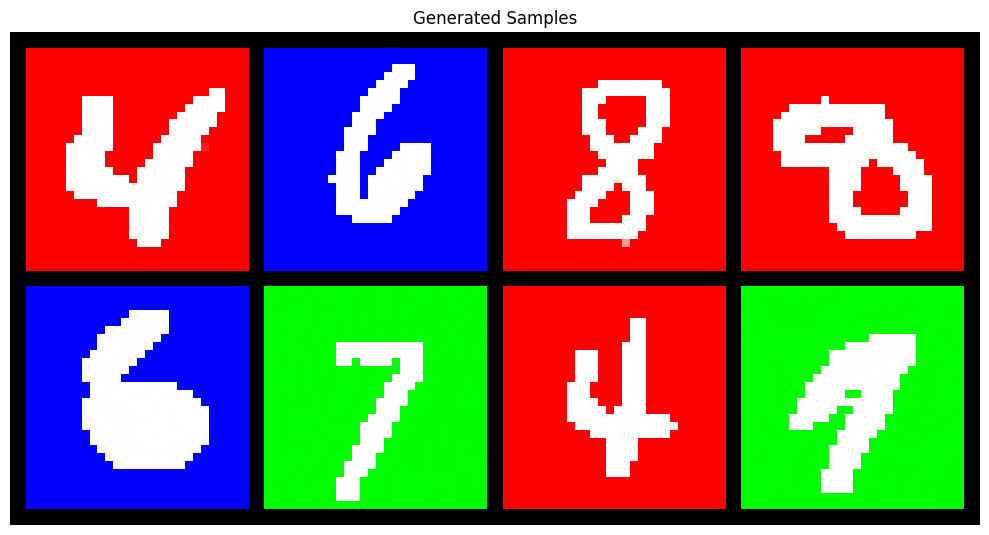

In [14]:
with torch.no_grad():
    alphas_cumprod = diffusion.alphas_cumprod.cpu() 
    target_var = 0.105
    t_dae = torch.argmin(torch.abs(1.0 - alphas_cumprod - target_var)).item()

t_dae = 200
print(t_dae)

samples = sample_with_dae(ddpm, dae, t_dae=t_dae, batch_size=8)
show_samples(samples)

### FID

In [15]:
from torch.utils.data import Dataset, DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
from PIL import Image

class ImageFolderDataset(Dataset):
    """Dataset for loading images from a folder for FID computation."""
    def __init__(self, root, image_size=299):
        self.root = Path(root)
        exts = [".jpg", ".jpeg", ".png", ".bmp", ".webp"]
        self.paths = sorted(
            p for ext in exts for p in self.root.rglob(f"*{ext}")
        )

        if len(self.paths) == 0:
            raise RuntimeError(f"No images found in {self.root}")

        self.transform = T.Compose([
            T.ConvertImageDtype(torch.float32),
        ])
        self.resize = T.Resize((image_size, image_size))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")  
        img = self.resize(img)
        img = T.functional.to_tensor(img)
        return img


@torch.no_grad()
def compute_fid(
    real_dir: str,
    fake_dir: str,
    batch_size: int = 16, 
    device: str = None,
    num_workers: int = 4,
) -> float:
    """
    Compute FID score between real and generated images.
    
    Args:
        real_dir: Path to directory containing real images
        fake_dir: Path to directory containing generated images
        batch_size: Batch size for processing
        device: Device to use for computation
        num_workers: Number of workers for data loading
    
    Returns:
        FID score (lower is better)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Clear GPU cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    real_ds = ImageFolderDataset(real_dir)
    fake_ds = ImageFolderDataset(fake_dir)

    real_loader = DataLoader(
        real_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
    )
    fake_loader = DataLoader(
        fake_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
    )

    fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    fid.eval()
    for imgs in real_loader:
        imgs = imgs.to(device)
        fid.update(imgs, real=True)
        del imgs  # Free memory immediately

    for imgs in fake_loader:
        imgs = imgs.to(device)
        fid.update(imgs, real=False)
        del imgs  # Free memory immediately

    value = fid.compute().item()
    
    # Clean up FID model to free GPU memory
    del fid
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return value

def save_samples_to_dir(samples: torch.Tensor, output_dir: Path, prefix: str = "sample"):
    """Save tensor samples as individual images to a directory."""
    output_dir.mkdir(parents=True, exist_ok=True)

    for i, img in enumerate(samples):
        img_path = output_dir / f"{prefix}_{i:04d}.png"
        save_image(img, img_path)

    return output_dir

In [16]:
import time 
import torchvision.transforms as T

REAL_IMAGES_DIR = "./data/testing"
COMPARE_SAMPLES = 1000                   
FID_OUTPUT_DIR = Path("./results/fid_evaluation")
FID_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

### ddpm

In [9]:
print("\nGenerating DDPM samples for FID comparison...")
ddpm_output_dir = FID_OUTPUT_DIR / f"DDPM_full"
ddpm_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_ddpm_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DDPM samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)
    with torch.no_grad():
        samples = ddpm.sample(batch_size=current_batch_size)  
    all_ddpm_samples.append(samples.cpu())

ddpm_samples = torch.cat(all_ddpm_samples, dim=0)[:COMPARE_SAMPLES]
ddpm_gen_time = time.time() - start_time

save_samples_to_dir(ddpm_samples, ddpm_output_dir)

print("Computing DDPM FID score...")
ddpm_fid = compute_fid(REAL_IMAGES_DIR, str(ddpm_output_dir), device=device)

print(f"\nDDPM Results:")
print(f"  - Generation time: {ddpm_gen_time:.2f}s")
print(f"  - FID Score: {ddpm_fid:.2f}")


Generating DDPM samples for FID comparison...


Generating DDPM samples: 100%|█████████████████████████████████████████████████████████| 16/16 [03:18<00:00, 12.41s/it]


Computing DDPM FID score...

DDPM Results:
  - Generation time: 198.58s
  - FID Score: 6.61


### t_dae = 200

In [17]:
print("\nGenerating DAE+DDPM samples for FID comparison...")
dae_output_dir = FID_OUTPUT_DIR / f"DAE_DDPM_t{t_dae}"
dae_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_dae_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DAE+DDPM samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)

    with torch.no_grad():
        samples = sample_with_dae(
            ddpm,
            dae,
            t_dae=t_dae,
            batch_size=current_batch_size,
        )

    all_dae_samples.append(samples.cpu())

dae_samples = torch.cat(all_dae_samples, dim=0)[:COMPARE_SAMPLES]
dae_gen_time = time.time() - start_time

save_samples_to_dir(dae_samples, dae_output_dir)

print("Computing DAE+DDPM FID score...")
dae_fid = compute_fid(REAL_IMAGES_DIR, str(dae_output_dir), device=device)

print(f"\nDAE+DDPM Results:")
print(f"  - Generation time: {dae_gen_time:.2f}s")
print(f"  - FID Score: {dae_fid:.2f}")


Generating DAE+DDPM samples for FID comparison...


Generating DAE+DDPM samples: 100%|█████████████████████████████████████████████████████| 16/16 [02:31<00:00,  9.46s/it]


Computing DAE+DDPM FID score...

DAE+DDPM Results:
  - Generation time: 151.41s
  - FID Score: 6.73


### t_dae = 100

In [19]:
print("\nGenerating DAE+DDPM samples for FID comparison...")
dae_output_dir = FID_OUTPUT_DIR / f"DAE_DDPM_t{t_dae}"
dae_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_dae_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DAE+DDPM samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)

    with torch.no_grad():
        samples = sample_with_dae(
            ddpm,
            dae,
            t_dae=t_dae,
            batch_size=current_batch_size,
        )

    all_dae_samples.append(samples.cpu())

dae_samples = torch.cat(all_dae_samples, dim=0)[:COMPARE_SAMPLES]
dae_gen_time = time.time() - start_time

save_samples_to_dir(dae_samples, dae_output_dir)

print("Computing DAE+DDPM FID score...")
dae_fid = compute_fid(REAL_IMAGES_DIR, str(dae_output_dir), device=device)

print(f"\nDAE+DDPM Results:")
print(f"  - Generation time: {dae_gen_time:.2f}s")
print(f"  - FID Score: {dae_fid:.2f}")


Generating DAE+DDPM samples for FID comparison...


Generating DAE+DDPM samples: 100%|█████████████████████████████████████████████████████| 16/16 [02:58<00:00, 11.14s/it]


Computing DAE+DDPM FID score...

DAE+DDPM Results:
  - Generation time: 178.32s
  - FID Score: 5.56


### t_dae = 1

In [8]:
print("\nGenerating DAE+DDPM samples for FID comparison...")
dae_output_dir = FID_OUTPUT_DIR / f"DAE_DDPM_t{t_dae}"
dae_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_dae_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DAE+DDPM samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)

    with torch.no_grad():
        samples = sample_with_dae(
            ddpm,
            dae,
            t_dae=t_dae,
            batch_size=current_batch_size,
        )

    all_dae_samples.append(samples.cpu())

dae_samples = torch.cat(all_dae_samples, dim=0)[:COMPARE_SAMPLES]
dae_gen_time = time.time() - start_time

save_samples_to_dir(dae_samples, dae_output_dir)

print("Computing DAE+DDPM FID score...")
dae_fid = compute_fid(REAL_IMAGES_DIR, str(dae_output_dir), device=device)

print(f"\nDAE+DDPM Results:")
print(f"  - Generation time: {dae_gen_time:.2f}s")
print(f"  - FID Score: {dae_fid:.2f}")


Generating DAE+DDPM samples for FID comparison...


Generating DAE+DDPM samples: 100%|█████████████████████████████████████████████████████| 16/16 [03:19<00:00, 12.46s/it]


Computing DAE+DDPM FID score...

DAE+DDPM Results:
  - Generation time: 199.29s
  - FID Score: 5.79
